# Integration Verification
We use this notebook to verify that the integration and intersection is working properly.

In [1]:
%cd /home/giorgian/Documente/Cercetare/Fairness/nn_fairness

/home/giorgian/Documente/Cercetare/Fairness/nn_fairness


In [4]:
from quad import integrate
from nnenum.lpinstance import LpInstance
import pickle
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from polytope import Polytope, reduce
from compute_volume import dd_extreme
import compute_volume as cv
import swiglpk as glpk
import glpk_util
from scipy.integrate import quad

In [5]:
def create_lpi(A, b):
    lpi = LpInstance()
    lpi.add_cols([str(i) for i in range(A.shape[1])])
    for row, rhs in zip(A, b):
        lpi.add_dense_row(row, rhs)
    return lpi

def create_plot_2d(A, b, x_bounds=(0, 2), y_bounds=(0, 2), num=50, n_ticks=11):
    
    X, Y = np.meshgrid(np.linspace(*x_bounds, num=num), np.linspace(*y_bounds, num=num), indexing='xy')
    C = np.stack([X, Y], axis=-1)
    inner = np.all(np.einsum('ij,abj->abi', A, C) <= b, axis=-1)
    fig, axes = plt.subplots()
    ret = axes.imshow(inner, origin='lower')
    # Setting tick locations
    x_ticks = np.linspace(0, num, n_ticks)
    y_ticks = np.linspace(0, num, n_ticks)

    # Setting tick labels
    x_labels = map(lambda x: str(round(x, 2)), np.linspace(*x_bounds, n_ticks))
    y_labels = map(lambda x: str(round(x, 2)), np.linspace(*y_bounds, n_ticks))

    axes.set_xticks(x_ticks)
    axes.set_yticks(y_ticks)

    axes.set_xticklabels(x_labels)
    axes.set_yticklabels(y_labels)
    
    return ret

def compute_intersection_lpi(lpi1, lpi2):
    """compute the intersection between two lpis"""

    # sanity checks
    assert lpi1.get_num_cols() == lpi2.get_num_cols()

    cols = lpi1.get_num_cols()

    assert np.allclose(lpi1._get_col_bounds(), lpi2._get_col_bounds())

    rv = LpInstance(lpi1)
    # add constraints of lpi 2 to rv

    rhs = lpi2.get_rhs()
    mat = lpi2.get_constraints_csr().toarray()

    for row, val in zip(mat, rhs):
        rv.add_dense_row(row, val)

    return rv

def quad_integrate_polytope(A, b, func_to_integrate=None):
    """use scipy.quad to integrate a function over a polytope domain

    params are the leq constraints Ax <= b

    if func_to_integrate is None, assumes function is 1 everywhere (returns volume)
    """

    lp = glpk_util.from_constraints(A, b)
    #print(glpk_util.to_str(lp))

    rv = quad_integrate_glpk_lp(lp, func_to_integrate)

    glpk.glp_delete_prob(lp)

    return rv


def quad_integrate_glpk_lp(glpk_lp_instance, func_to_integrate=None):
    """use scipy.quad to integrate a function over a polytope domain

    takes in polytope as a gplk lp instance

    if func_to_integrate is None, assumes function is 1 everywhere (returns volume)
    """

    if func_to_integrate is None:
        func_to_integrate = lambda *args: 1

    integrator = LpIntegrator(glpk_lp_instance)

    def eval_func(x, *args):
        """evaluate the function"""

        if len(args) + 1 < integrator.num_cols:
            dim_lb, dim_ub = integrator.get_bounds(*args, x)

            rv = quad(eval_func, dim_lb, dim_ub, args=(*args, x))[0]
        else:
            # base case: last dimension
            rv = func_to_integrate(*args, x)

        return rv

    lb, ub = integrator.get_bounds()
    rv = quad(eval_func, lb, ub)[0]

    return rv

class LpIntegrator:
    """an LP being integrated"""

    def __init__(self, lp):

        self.lp = lp
        self.num_cols = glpk_util.get_num_cols(lp)

    def get_bounds(self, *fixed_cols):
        """get bounds of the next column, given a list of fixed values for columns"""

        lp = glpk.glp_create_prob()
        glpk.glp_copy_prob(lp, self.lp, glpk.GLP_OFF)

        # fix the variables
        for i, val in enumerate(fixed_cols):
            glpk.glp_set_col_bnds(lp, i + 1, glpk.GLP_FX, float(val), float(val))
       
        direction_vec = [0] * self.num_cols

        cur_col = len(fixed_cols)
        assert cur_col < self.num_cols, f"get_bounds called with fixed_cols={fixed_cols}, but num_cols = {self.num_cols}"

        direction_vec[cur_col] = 1
        glpk_util.set_minimize_direction(lp, direction_vec)

        params = glpk_util.default_params()
        simplex_res = glpk.glp_simplex(lp, params)
        assert simplex_res == 0
        lb = glpk.glp_get_col_prim(lp, int(1 + cur_col))

        direction_vec[cur_col] = -1
        glpk_util.set_minimize_direction(lp, direction_vec)

        simplex_res = glpk.glp_simplex(lp, params)
        assert simplex_res == 0
        ub = glpk.glp_get_col_prim(lp, int(1 + cur_col))

        glpk.glp_delete_prob(lp)

        return lb, ub

In [6]:
class UniformPDF:
    
    def __init__(self, n):
        self.n = n
    def sample(self, *x):
        return 1
    
    @property
    def regions(self):
        return [((0, 1),)*self.n]

In [7]:
class LinearPDF:
    
    def __init__(self, n, coeffs=None):
        self.n = n
        if coeffs is None:
            self.coeffs = np.ones(n)
        else:
            self.coeffs = np.array(coeffs)
    def sample(self, *x):
        print(f'f({x})={np.dot(self.coeffs, np.array(x))}')
        return np.dot(self.coeffs, np.array(x))
    
    @property
    def regions(self):
        return [((0, 1),)*self.n]

## 2D Square
We create a simple unit square with four corners

In [6]:
# First test: simple square
A = np.concatenate([-np.eye(2), np.eye(2)], axis=0)
b = np.array([0, 0, 1, 1])
lpi_1 = create_lpi(A, b, )
pdf = UniformPDF(2)


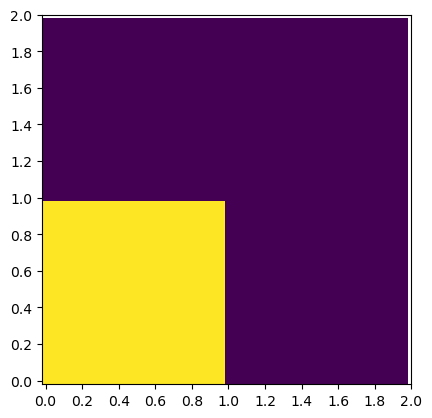

In [7]:
create_plot_2d(A, b)

In [8]:
integrate(lpi_1, pdf, {})

1.0

## Right Triangle

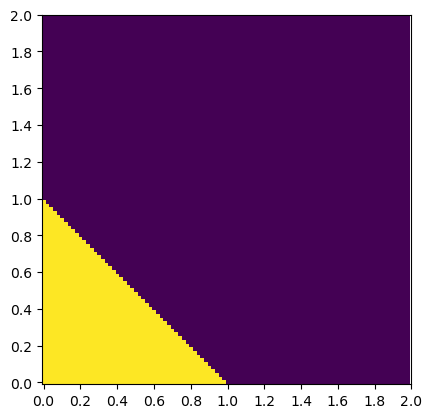

In [9]:
# First test: simple square
A = np.concatenate([-np.eye(2), np.eye(2), np.array([[1, 1]])], axis=0)
b = np.array([0, 0, 1, 1, 1])
lpi_2 = create_lpi(A, b)
pdf = UniformPDF(2)
create_plot_2d(A, b, num=100)

In [10]:
integrate(lpi_2, pdf, {})

0.4999999999999999

## Intersection of Square and Right Triangle

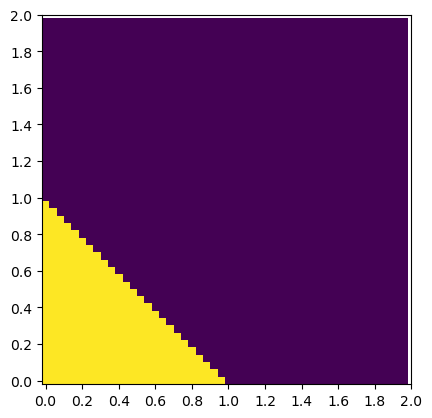

In [25]:
lpi_3 = compute_intersection_lpi(lpi_1, lpi_2)
A = lpi_3.get_constraints_csr().toarray()
b = lpi_3.get_rhs()
create_plot_2d(A, b)

In [13]:
integrate(lpi_3, pdf, {})

0.4999999999999999

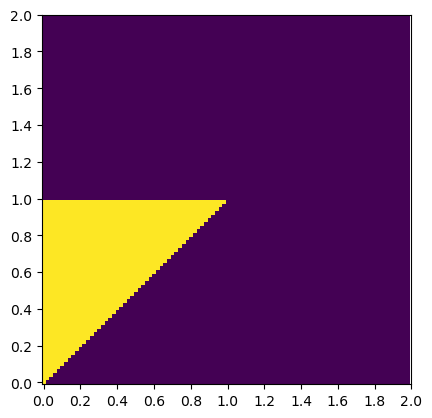

In [14]:
# First test: simple square
A = np.concatenate([-np.eye(2), np.eye(2), np.array([[1, -1]])], axis=0)
b = np.array([0, 0, 1, 1, 0])
lpi_4 = create_lpi(A, b)
pdf = UniformPDF(2)
create_plot_2d(A, b, num=100)

In [15]:
integrate(lpi_4, pdf, {})

0.5

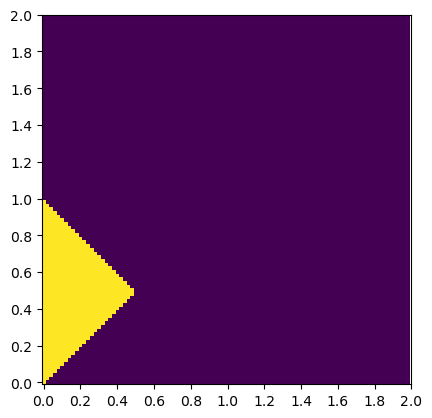

In [16]:
lpi_5 = compute_intersection_lpi(lpi_2, lpi_4)
A = lpi_5.get_constraints_csr().toarray()
b = lpi_5.get_rhs()
create_plot_2d(A, b, num=100)

In [17]:
integrate(lpi_5, pdf, {})

0.25

## Linear PDF

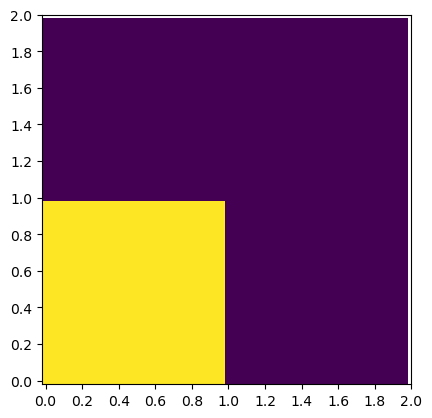

In [26]:
# First test: simple square
A = np.concatenate([-np.eye(2), np.eye(2)], axis=0)
b = np.array([0, 0, 1, 1])
lpi_1 = create_lpi(A, b, )
pdf = LinearPDF(2)
create_plot_2d(A, b)

In [24]:
# Should give 1.0
integrate(lpi_1, pdf, {})

f((1.0, 1.0))=2.0
f((1.0, 0.0))=1.0
f((5.551115123125783e-17, 1.0))=1.0
f((5.551115123125783e-17, 5.551115123125783e-17))=1.1102230246251565e-16


1.0

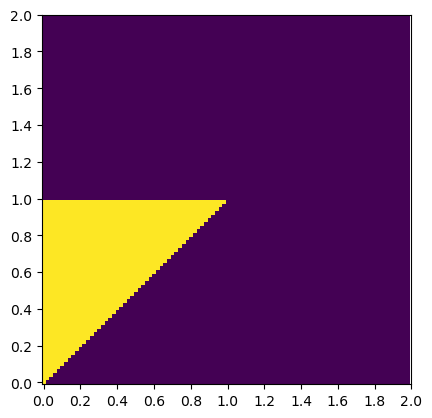

In [29]:
# First test: simple square
A = np.concatenate([-np.eye(2), np.eye(2), np.array([[1, -1]])], axis=0)
b = np.array([0, 0, 1, 1, 0])
lpi_4 = create_lpi(A, b)
pdf = LinearPDF(2)
create_plot_2d(A, b, num=100)

In [36]:
# Should give 1/2
integrate(lpi_4, pdf, {})

f((0.0, -1.1102230246251565e-16))=-1.1102230246251565e-16
f((0.0, 1.0))=1.0
f((1.0, 1.0))=2.0


0.49999999999999994

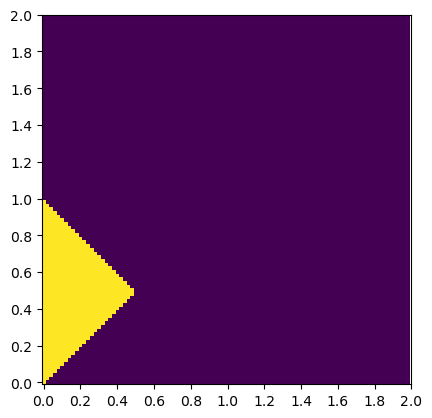

In [31]:
lpi_5 = compute_intersection_lpi(lpi_2, lpi_4)
A = lpi_5.get_constraints_csr().toarray()
b = lpi_5.get_rhs()
create_plot_2d(A, b, num=100)

In [37]:
# Should give 1/8
integrate(lpi_5, pdf, {})

f((-2.7755575615628914e-17, 1.0000000000000002))=1.0000000000000002
f((0.0, 0.0))=0.0
f((0.5, 0.5))=1.0


0.16666666666666666

## Integration of Power of a Linear Form over A Simplex

Based on [this paper](https://arxiv.org/abs/1108.0117), there is a simple formula for the integral of a polynomial of a linear form over a $d$-simplex. $s_1\ldots s_{d+1}$ are the vertices of the $d$-simplex.

$\int_{\Delta} \langle \ell, x\rangle^M dm = d!\text{vol}(\Delta, dm)\frac{M!}{(M+d)!}\sum_{i=1}^{d+1} \frac{\langle \ell, x\rangle^{M+d}}{\prod_{j\neq i} \langle \ell, s_i - s_j\rangle}$

We can derive as a collary from the paper the following formula for the integral of a linear integration over a $d$-simplex:

$\int_{\Delta} \langle \ell, x\rangle^M dm = d!\text{vol}(\Delta, dm)e^{\langle \ell, x\rangle}\sum_{i=1}^{d+1} \frac{1}{\prod_{j\neq i} \langle \ell, s_i - s_j\rangle}$


In [83]:
from math import factorial as fac

vertices = np.array([[0, 0],[0, 1], [1, 1]])
vol = 0.5
M = 2
d = 2
term = 0
def f(x):
    return sum(x)
for i in range(len(vertices)):
    prod = 1
    for j in range(len(vertices)):
        if i == j:
            continue
        prod *= f(vertices[i] - vertices[j])
    term += f(vertices[i])**(M+d)/prod
    


In [11]:
# Should be 7/12
fac(d)*vol*fac(M)/fac(M + d) * term

0.5833333333333333

In [12]:
A = np.array([
    [-1, 1],
    [0, 1],
    [3, 2],
    [-1, 0],
    [0, -1]
])
b = np.array([
    2, 4, 15, 0, 0
])
p = reduce(Polytope(A, b))

In [21]:
from importlib import reload
reload(cv)

<module 'compute_volume' from '/home/giorgian/Documente/Cercetare/Fairness/nn_fairness/compute_volume.py'>

In [14]:
coeffs = np.random.uniform(size=(3, 2))
P = np.arange(3)

In [18]:
cv.lawrence_integrate_linear_form(p, cv.dd_extreme, coeffs=coeffs, P=P)

(array([12.66667, 32.30612, 28.22196]),
 array([[2.     , 4.     ],
        [0.     , 0.     ],
        [0.     , 2.     ],
        [5.     , 0.     ],
        [2.33333, 4.     ]]))

In [17]:
cv.lawrence_integrate_polytope_slow(p, cv.dd_extreme, coeffs=coeffs[1], P=P[1])

(32.30611856363544,
 array([[2.     , 4.     ],
        [0.     , 0.     ],
        [0.     , 2.     ],
        [5.     , 0.     ],
        [2.33333, 4.     ]]))

In [104]:
cv.lawrence_integrate_polytope_slow(p, cv.dd_extreme, coeffs=coeffs[2], P=P[2])

(34.905818069356656,
 array([[2.     , 4.     ],
        [0.     , 0.     ],
        [0.     , 2.     ],
        [5.     , 0.     ],
        [2.33333, 4.     ]]))

In [61]:
from importlib import reload
reload(cv)

<module 'compute_volume' from '/home/giorgian/Documente/Cercetare/Fairness/nn_fairness/compute_volume.py'>

In [43]:
cv.lawrence_integrate_linear_form(p, cv.dd_extreme, coeffs=coeffs, P=P)

(array([12.66667, 32.30612, 28.22196]),
 array([[2.     , 4.     ],
        [0.     , 0.     ],
        [0.     , 2.     ],
        [5.     , 0.     ],
        [2.33333, 4.     ]]))

In [62]:
A = np.array([
    [0, 1],
    [0, -1],
    [1, 0],
    [-1, 0]
])
b = np.array([
    1, 0, 1, 0
])
p = reduce(Polytope(A, b))

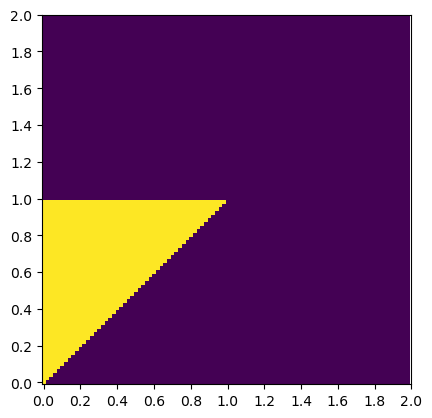

In [79]:
# First test: simple square
A = np.concatenate([-np.eye(2), np.eye(2), np.array([[1, -1]])], axis=0)
b = np.array([0, 0, 1, 1, 0])
create_plot_2d(A, b, num=100)
p = reduce(Polytope(A, b))

In [81]:
coeffs = np.array([[1, 1], [1, 1+2j], [-3+2j, 4-8j]])

In [82]:
cv.lawrence_integrate_linear_exp(p, cv.dd_extreme, coeffs=coeffs)

(array([1.47625+0.j     , 0.09853+1.35162j, 1.75817-0.12018j]),
 array([[1., 1.],
        [0., 1.],
        [0., 0.]]))

In [ ]:
np.einsum('cij,vjk'->)

In [ ]:
#c_B @ np.linalg.inv(A_B) @ A_N)
# c_B: (3, 5, 5) (coeff, vertex, f)
# c_N (3, 5, 2)
# A_B: (5, 5, 5) (vertex, f, f)
# A_N (5, 5, 2)

In [34]:
cv.lawrence_integrate_polytope(p, cv.dd_extreme, coeffs=coeffs, P=P)[0]

c.shape=(4, 7) c_N.shape=(4, 5, 2) c_B.shape=(4, 5, 5)
A_B.shape=(5, 5, 5) A_N.shape=(5, 5, 2)


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,5,5)->(4,newaxis,newaxis) (5,5,5)->(5,newaxis,newaxis)  and requested shape (5,5)

In [26]:
import math
from scipy.special import factorial
factorial(np.array([4, 5, 6]))

array([ 24., 120., 720.])

In [142]:
A = np.concatenate([-np.eye(2), np.eye(2)], axis=0)
b = np.array([0, 0, 1, 1])
p = reduce(Polytope(A, b))

In [143]:
cv.lawrence_integrate_polytope_slow(p, cv.dd_extreme, coeffs=np.array([6, -3]), P=4)[0]

86.4

In [144]:
cv.lawrence_integrate_polytope(p, cv.dd_extreme, coeffs=np.array([6, -3]), P=4)[0]

86.4

In [159]:
cv.lawrence_integrate_polytope_slow(p, cv.dd_extreme, coeffs=np.array([2, 2]), P=2)[0]

4.666666666666666

In [157]:
cv.lawrence_integrate_polytope(p, cv.dd_extreme, coeffs=np.array([2, 2]), P=2)[0]

4.666666666666667

In [158]:
quad_integrate_polytope(p.A, p.b, lambda x, y: (2*x + 2*y)**2)

4.666666666666666

In [163]:
vertices = np.random.normal(size=(500, 200))

In [164]:
vertices

array([[-2.37667,  0.08312,  0.09779, ..., -0.9436 , -0.51105, -0.07377],
       [ 0.04836,  0.14266, -1.25115, ..., -0.90037,  0.50388, -0.57966],
       [-1.40117,  0.1994 , -1.25702, ..., -1.65793, -0.39542,  0.24319],
       ...,
       [-0.63823, -0.4692 , -0.41608, ...,  2.04812, -0.99656,  0.34516],
       [-0.24358, -0.86994,  0.70537, ...,  1.26658,  0.83478,  0.99935],
       [ 0.07721,  0.05995,  0.34639, ..., -0.84871, -0.33205,  1.8765 ]])

In [166]:
from scipy.spatial import ConvexHull

In [ ]:
ConvexHull(vertices)